# Predict T20 Match Score and Result Using Python
---

In this small hands-on workshop, we are going to take a look at how you can use Python and simple statistical modeling to predict the turnout of a T20 cricket match. 

The techniques discussed in this notebook are quite generalized, but the same can be translated into more advanced models for predicting match predictions with a much higher accuracy.


## STEP 1: Importing Project Dependencies
---
The first step when it comes to any project is importing the required python modules that will allow you to work with and manipulate the data. 

In [162]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

## STEP 2: Loading the Data
---
The next step of the project will be to load the datasets so that we can then use them for data analysis and modeling.

In [163]:

project_root = os.path.dirname(os.getcwd())
data_dir = os.path.join(project_root, "data")

# loading batting data
batting_data_path = os.path.join(data_dir, "batting_t20.csv")
batting_df = pd.read_csv(batting_data_path)

bowling_data_path = os.path.join(data_dir, "bowling_t20.csv")
bowling_df = pd.read_csv(bowling_data_path)

fielding_data_path = os.path.join(data_dir, "fielding_t20.csv")
fielding_df = pd.read_csv(fielding_data_path)

In [164]:
# printing first 5 rows of batting data 
batting_df.head(5)

,Unnamed: 0,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,4s,6s,Unnamed: 15
0,0,V Kohli (INDIA),2010-2019,75,70,20,2633,94*,52.66,1907,138.07,0,24,2,247,71,NaN
1,1,RG Sharma (INDIA),2007-2019,104,96,14,2633,118,32.1,1905,138.21,4,19,6,234,120,NaN
2,2,MJ Guptill (NZ),2009-2019,83,80,7,2436,105,33.36,1810,134.58,2,15,2,215,113,NaN
3,3,Shoaib Malik (ICC/PAK),2006-2019,111,104,30,2263,75,30.58,1824,124.06,0,7,1,186,61,NaN
4,4,BB McCullum (NZ),2005-2015,71,70,10,2140,123,35.66,1571,136.21,2,13,3,199,91,NaN


In [165]:
# printing first 5 rows of bowling data 
bowling_df.head(5)

,Unnamed: 0,Player,Span,Mat,Inns,Overs,Mdns,Runs,Wkts,BBI,Ave,Econ,SR,4,5,Unnamed: 14
0,0,SL Malinga (SL),2006-2019,79,79,284.5,1,2061,106,5/6,19.44,7.23,16.1,1,2,NaN
1,1,Shahid Afridi (ICC/PAK),2006-2018,99,97,361.2,4,2396,98,4/11,24.44,6.63,22.1,3,0,NaN
2,2,Shakib Al Hasan (BDESH),2006-2019,76,75,277.5,2,1894,92,5/20,20.58,6.81,18.1,3,1,NaN
3,3,Saeed Ajmal (PAK),2009-2015,64,63,238.2,2,1516,85,4/19,17.83,6.36,16.8,4,0,NaN
4,4,Umar Gul (PAK),2007-2016,60,60,200.3,2,1443,85,5/6,16.97,7.19,14.1,4,2,NaN


In [166]:
# printing first 5 rows of fielding data 
fielding_df.head(5)

,Unnamed: 0,Player,Span,Mat,Inns,Dis,Ct,St,Ct Wk,Ct Fi,MD,D/I,Unnamed: 11
0,0,MS Dhoni (INDIA),2006-2019,98,97,91,57,34,57,0,5 (5ct 0st),0.938,NaN
1,1,AB de Villiers (SA),2006-2017,78,78,72,65,7,21,44,4 (4ct 0st),0.9229999999999999,NaN
2,2,D Ramdin (WI),2006-2019,71,71,63,43,20,43,0,4 (4ct 0st),0.887,NaN
3,3,Kamran Akmal (PAK),2006-2017,58,58,60,28,32,28,0,4 (0ct 4st),1.034,NaN
4,4,Mushfiqur Rahim (BDESH),2006-2019,84,82,59,31,28,30,1,3 (1ct 2st),0.7190000000000001,NaN


## STEP 3: Data Preprocessing
---

In this step, we will firstly clean the dataset and then apply some feature engineering techniques to extract some more features from the dataset.

First, we will remove the unnecessary columns from the dataset.

In [167]:
# dropping unnecessary columns from batting data
batting_df.drop(columns=["Unnamed: 0", "Span", "Unnamed: 15"], inplace=True)

# dropping unnecessary columns from bowling data
bowling_df.drop(columns=["Unnamed: 0", "Span", "Unnamed: 14", "BBI"], inplace=True)

# dropping unnecessary columns from fielding data
fielding_df.drop(columns=["Unnamed: 0", "Span", "Unnamed: 11"], inplace=True)

In [168]:
bowling_df.head(5)

,Player,Mat,Inns,Overs,Mdns,Runs,Wkts,Ave,Econ,SR,4,5
0,SL Malinga (SL),79,79,284.5,1,2061,106,19.44,7.23,16.1,1,2
1,Shahid Afridi (ICC/PAK),99,97,361.2,4,2396,98,24.44,6.63,22.1,3,0
2,Shakib Al Hasan (BDESH),76,75,277.5,2,1894,92,20.58,6.81,18.1,3,1
3,Saeed Ajmal (PAK),64,63,238.2,2,1516,85,17.83,6.36,16.8,4,0
4,Umar Gul (PAK),60,60,200.3,2,1443,85,16.97,7.19,14.1,4,2


Now that we have removed the unnecessary columns, the next step is feature extraction. For the first step, we will normalize the `Player` column to separate and derive the name and country of the players.

In [169]:
def separate_name_country_from_data(df: pd.DataFrame) -> None:
    player_arr = df["Player"].to_numpy()
    player_name = list()
    player_country = list()
    for player in player_arr:
        info = player.split(" (")
        p_name, p_country = info[0], info[-1]
        p_country = p_country.strip(")").replace("ICC", "").replace("World", "").replace("/", "").upper()
        player_name.append(p_name)
        player_country.append(p_country)
    df["Player"] = np.array(player_name)
    df["Country"] = np.array(player_country)

In [170]:
# separating counntry in batting data 
separate_name_country_from_data(batting_df)

# separating counntry in bowling data 
separate_name_country_from_data(bowling_df)

# separating counntry in fielding data 
separate_name_country_from_data(fielding_df)

Now, let's convert the datatype to numeric format for some of the columns.

In [171]:
def convert_to_numeric(df: pd.DataFrame, columns: list):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

In [172]:
# converting for batting df
convert_to_numeric(df=batting_df, columns=["Mat", "Inns", "NO", "Runs", "Ave", "BF", "SR", "100", "50", "0", "4s", "6s"])

# converting for bowling df
convert_to_numeric(df=bowling_df, columns=["Mat", "Inns", "Overs", "Mdns", "Runs", "Wkts", "Ave", "Econ", "SR", "4", "5"])

# converting for fielding df
convert_to_numeric(df=fielding_df, columns=["Mat", "Inns", "Dis", "Ct", "St", "Ct Wk", "Ct Fi", "D/I"])

Now, let us remove the NaN values (garbage values) from the dataset.

In [173]:
# removing nan values from batting df
def remove_nan(df: pd.DataFrame) -> None:
    df.replace("-", np.nan, inplace=True)
    df.dropna(inplace=True)
    df.reset_index(drop=True)

In [174]:
# removing nan from batting df
remove_nan(batting_df)

# removing nan from bowlinf df
remove_nan(bowling_df)

# removing nan from fielding df
remove_nan(fielding_df)

## STEP 4: Exploratory Data Analysis
---

In this step, we will perform EDA on the datasets to extract some insights and trends from the data that will help us determing the performances of different teams.

First, let us see by country the distribution of top 50 players in each category. For this, let us factor the normalized product of number of innings played and the total score of a player.

In [175]:
batting_df["normalized_score"] = batting_df["Runs"] * (batting_df["Runs"] / batting_df["Inns"])
batting_df["normalized_score"] = batting_df["normalized_score"] / batting_df["normalized_score"].max()

batting_sorted_df = batting_df.sort_values(by=["normalized_score"], ascending=False).reset_index(drop=True)
batting_sorted_df

,Player,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,4s,6s,Country,normalized_score
0,V Kohli,75,70.0,20.0,2633.0,94*,52.66,1907.0,138.07,0.0,24.0,2.0,247.0,71.0,INDIA,1.000000
1,MJ Guptill,83,80.0,7.0,2436.0,105,33.36,1810.0,134.58,2.0,15.0,2.0,215.0,113.0,NZ,0.748964
2,RG Sharma,104,96.0,14.0,2633.0,118,32.10,1905.0,138.21,4.0,19.0,6.0,234.0,120.0,INDIA,0.729167
3,BB McCullum,71,70.0,10.0,2140.0,123,35.66,1571.0,136.21,2.0,13.0,3.0,199.0,91.0,NZ,0.660581
4,AJ Finch,58,58.0,9.0,1878.0,172,38.32,1200.0,156.50,2.0,11.0,4.0,182.0,90.0,AUS,0.613987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667,P Kerai,6,1.0,0.0,0.0,0,0.00,1.0,0.00,0.0,0.0,1.0,0.0,0.0,KENYA,0.000000
1668,RN Lewis,1,1.0,0.0,0.0,0,0.00,4.0,0.00,0.0,0.0,1.0,0.0,0.0,WI,0.000000
1669,CA Liyanage,2,2.0,1.0,0.0,0*,0.00,1.0,0.00,0.0,0.0,1.0,0.0,0.0,MALD,0.000000
1670,AJ McKay,2,1.0,0.0,0.0,0,0.00,1.0,0.00,0.0,0.0,1.0,0.0,0.0,NZ,0.000000


For bowling, this normalized score will factor in total runs, wickets taken and overs bowled.

In [176]:
bowling_df["normalized_perf"] = bowling_df["Runs"] * bowling_df["Wkts"] / bowling_df["Overs"] 
bowling_df["normalized_perf"] = bowling_df["normalized_perf"] / bowling_df["normalized_perf"].max()

bowling_sorted_df = bowling_df.sort_values(by=["normalized_perf"], ascending=False).reset_index(drop=True)
bowling_sorted_df

,Player,Mat,Inns,Overs,Mdns,Runs,Wkts,Ave,Econ,SR,4,5,Country,normalized_perf
0,SL Malinga,79,79.0,284.5,1.0,2061.0,106.0,19.44,7.23,16.1,1.0,2.0,SL,1.000000
1,Shahid Afridi,99,97.0,361.2,4.0,2396.0,98.0,24.44,6.63,22.1,3.0,0.0,PAK,0.846571
2,TG Southee,66,64.0,233.3,2.0,1954.0,75.0,26.05,8.36,18.6,0.0,1.0,NZ,0.818031
3,Shakib Al Hasan,76,75.0,277.5,2.0,1894.0,92.0,20.58,6.81,18.1,3.0,1.0,BDESH,0.817717
4,Umar Gul,60,60.0,200.3,2.0,1443.0,85.0,16.97,7.19,14.1,4.0,2.0,PAK,0.797449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1136,A Bhattarai,1,1.0,3.0,0.0,12.0,1.0,12.00,4.00,18.0,0.0,0.0,NEPAL,0.005209
1137,SR Welsh,1,1.0,3.0,0.0,6.0,2.0,3.00,2.00,9.0,0.0,0.0,CAN,0.005209
1138,Ismat Ullah,4,2.0,4.0,0.0,16.0,1.0,16.00,4.00,24.0,0.0,0.0,,0.005209
1139,SG Borthwick,1,1.0,4.0,0.0,15.0,1.0,15.00,3.75,24.0,0.0,0.0,ENG,0.004883


Now, let us plot the distribution of top-100 players country-wise.

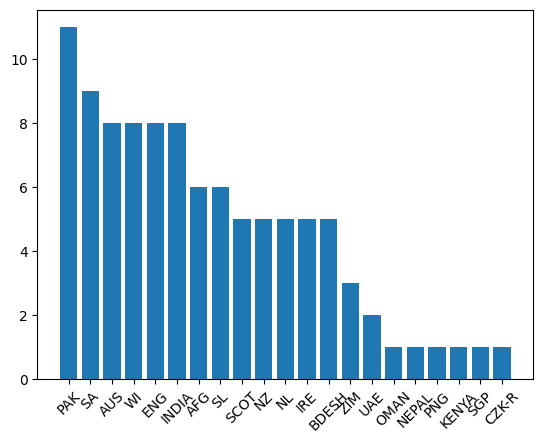

In [177]:
top_100_batting = batting_sorted_df.head(100)
player_count = top_100_batting.groupby("Country").count().sort_values(by=["Player"], ascending=False)["Player"]
plt.bar(player_count.index, player_count)
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.show()

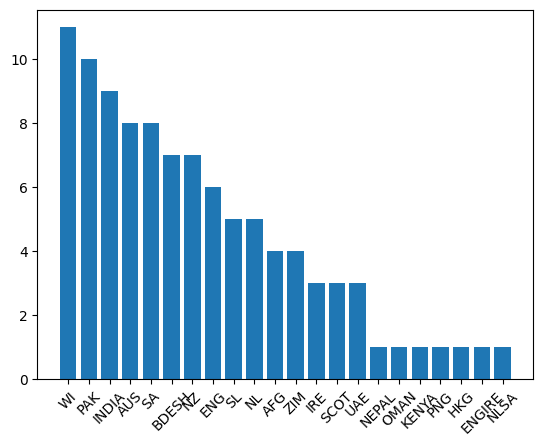

In [178]:
top_100_bowling = bowling_sorted_df.head(100)
player_count = top_100_bowling.groupby("Country").count().sort_values(by=["Player"], ascending=False)["Player"]
plt.bar(player_count.index, player_count)
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.show()

## STEP 5: Modeling a statistical model for determining which team will win
---

In this final step, we will try to derive a statistical model that will predict which of the two teams are going to win a given match.

Here, we will take the example of a fantasy cricket game. You can create two teams out of the players available, and based on the combined feature score of all the players of a team, our statistical model will try to predict which team will win.

Let's create v1 of our result predictor.

In [189]:
def calculate_batting_score(batting_df: pd.DataFrame, batsmen: list) -> float:
    score = 0
    for bat in batsmen:
        try:
            mask = batting_df['Player'].values == bat
            player = batting_df.loc[mask].iloc[0]
            player_score = player["Runs"] * (player["Runs"] / player["Inns"]) * player["SR"]
            score += player_score
        except:
            print(bat)
    return score        

In [190]:
def calculate_bowling_score(bowling_df: pd.DataFrame, bowlers: list) -> float:
    score = 0
    for bow in bowlers:
        try:
            mask = bowling_df['Player'].values == bow
            player = bowling_df.loc[mask].iloc[0]
            player_score = player["Runs"] / player["Overs"] * player["Wkts"] * player["Econ"]
            score += player_score
        except:
            print(bow)
    return score

In [193]:
def predict_winner(team_1: dict, team_2: dict, batting_df: pd.DataFrame, bowling_df: pd.DataFrame):
    
    # calculating combined feature score for team 1
    score_1 = 0
    batsmen_1, bowlers_1 = team_1["batsmen"], team_1["bowlers"]
    score_1 += calculate_batting_score(batting_df, batsmen_1)
    score_1 += calculate_bowling_score(bowling_df, bowlers_1)  
    
    # calculating combined feature score for team 2
    score_2 = 0
    batsmen_2, bowlers_2 = team_2["batsmen"], team_2["bowlers"]
    score_2 += calculate_batting_score(batting_df, batsmen_2)
    score_2 += calculate_bowling_score(bowling_df, bowlers_2)

    # calculating probabilities
    probab_1 = score_1 / (score_1 + score_2) * 100
    probab_2 = 100 - probab_1
    
    print(f"Probability of win: TEAM1({probab_1}):TEAM2({probab_2})")

In [194]:
team_1 = {
    "batsmen":['V Kohli', 'RG Sharma', 'MJ Guptill', 'Shoaib Malik', 'BB McCullum', 'DA Warner'],
    "bowlers":['SL Malinga', 'Shahid Afridi', 'Shakib Al Hasan', 'Saeed Ajmal'],
}

team_2 = {
    "batsmen":['Tamim Iqbal', 'MN Samuels', 'SK Raina', 'GJ Maxwell', 'Shakib Al Hasan', 'C Munro'],
    "bowlers":['Mohammad Hafeez', 'Sohail Tanvir', 'RE van der Merwe', 'WB Rankin'],
}

predict_winner(team_1, team_2, batting_df, bowling_df)

Probability of win: TEAM1(63.896382603139315):TEAM2(36.103617396860685)
